## Семинар 14. VAE в Pyro

In [1]:
%!pip install pyro-ppl

UsageError: Line magic function `%!pip` not found.


In [2]:
import os

import numpy as np
import torch
from pyro.contrib.examples.util import MNIST
import torch.nn as nn
import torchvision.transforms as transforms

import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util  # patches torchvision
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [3]:
assert pyro.__version__.startswith("1.8.6")
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
smoke_test = "CI" in os.environ

In [4]:
# for loading and batching MNIST dataset
def setup_data_loaders(batch_size=128, use_cuda=False):
    root = "./data"
    download = True
    trans = transforms.ToTensor()
    train_set = MNIST(root=root, train=True, transform=trans, download=download)
    test_set = MNIST(root=root, train=False, transform=trans)

    kwargs = {"num_workers": 10, "pin_memory": use_cuda}
    train_loader = torch.utils.data.DataLoader(
        dataset=train_set, batch_size=batch_size, shuffle=True, **kwargs
    )
    test_loader = torch.utils.data.DataLoader(
        dataset=test_set, batch_size=batch_size, shuffle=False, **kwargs
    )
    return train_loader, test_loader

In [5]:
train_loader, test_loader = setup_data_loaders(batch_size=256, use_cuda=True)

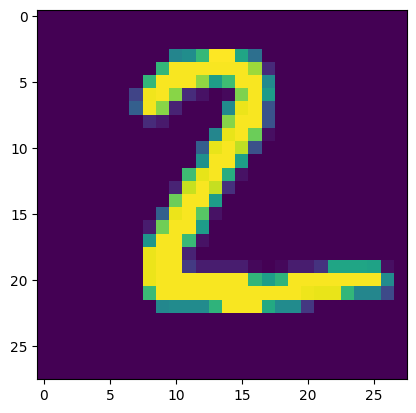

In [6]:
import matplotlib.pyplot as plt

plt.imshow(test_loader.dataset[1][0].detach().numpy()[0, :, :])

In [7]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim) -> None:
        super().__init__()
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, 28 * 28)

        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        hidden = self.softplus(self.fc1(z))
        loc_img = self.sigmoid(self.fc21(hidden))
        return loc_img

In [8]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim) -> None:
        super().__init__()

        self.fc1 = nn.Linear(28 * 28, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        self.softplus = nn.Softplus()

    def forward(self, x):
        x = x.reshape(-1, 28 * 28)

        hidden = self.softplus(self.fc1(x))

        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

In [9]:
class VAE(nn.Module):
    def __init__(self, z_dim, hidden_dim, use_cuda) -> None:
        super().__init__()
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)
        if use_cuda:
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # p(x,z) = p(x|z)p(z)
    def model(self, x):
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

            loc_img = self.decoder(z)

            pyro.sample(
                "obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784)
            )

    def guide(self, x):
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder(x)
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    def reconstruct_img(self, x):
        z_loc, z_scale = self.encoder(x)
        z = dist.Normal(z_loc, z_scale).sample()
        loc_img = self.decoder(z)
        return loc_img

In [10]:
def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.0
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, _ in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [11]:
def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.0
    # compute the loss over the entire test set
    for x, _ in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

In [12]:
# Run options
LEARNING_RATE = 1.0e-3
USE_CUDA = True

# Run only for a single iteration for testing
NUM_EPOCHS = 100
TEST_FREQUENCY = 5
z_dim = 2

In [13]:
# train_loader, test_loader = setup_data_loaders(batch_size=256, use_cuda=USE_CUDA)

# # clear param store
# pyro.clear_param_store()

# # setup the VAE
# vae = VAE(use_cuda=USE_CUDA, z_dim=z_dim, hidden_dim=500)

# # setup the optimizer
# adam_args = {"lr": LEARNING_RATE}
# optimizer = Adam(adam_args)

# # setup the inference algorithm
# svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

# train_elbo = []
# test_elbo = []
# # training loop
# for epoch in range(NUM_EPOCHS):
#     total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
#     train_elbo.append(-total_epoch_loss_train)
#     print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

#     if epoch % TEST_FREQUENCY == 0:
#         # report test diagnostics
#         total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
#         test_elbo.append(-total_epoch_loss_test)
#         print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

## Сохранение модели

In [14]:
# torch.save(vae.state_dict(), f"vae_z_dim-{vae.z_dim}_hid-{500}.pt")

## Визуализация модели

In [16]:
vae_loaded = VAE(z_dim=z_dim, hidden_dim=500, use_cuda=True)
vae_loaded.load_state_dict(torch.load(f"vae_z_dim-{z_dim}_hid-{500}.pt"))

RuntimeError: Error(s) in loading state_dict for VAE:
	Missing key(s) in state_dict: "encoder.fc21.weight", "encoder.fc21.bias", "encoder.fc22.weight", "encoder.fc22.bias", "decoder.fc21.weight", "decoder.fc21.bias". 
	Unexpected key(s) in state_dict: "encoder.fc2.weight", "encoder.fc2.bias", "encoder.fc31.weight", "encoder.fc31.bias", "encoder.fc32.weight", "encoder.fc32.bias", "decoder.fc2.weight", "decoder.fc2.bias", "decoder.fc31.weight", "decoder.fc31.bias". 